<a href="https://colab.research.google.com/github/phamnguyenlongvu/Computer-Vision/blob/main/Fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Import lib**

In [5]:
import pandas as pd
import numpy as np
import tensorflow as tf
import os

import tensorflow.keras as keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, GlobalAvgPool2D, Dropout
from tensorflow.keras.applications import ResNet50
import tensorflow.keras.applications as app
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import copy
from sklearn.metrics import classification_report
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam

**Download Data**

In [ ]:
! pip install kaggle

! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

# Download dataset
!kaggle datasets download -d puneet6060/intel-image-classification

# Unzip dataset
!unzip "/content/intel-image-classification.zip"

In [7]:
train_dir = '/content/seg_train/seg_train'
test_dir = '/content/seg_test/seg_test'

**Preprocess input**

In [ ]:
class_names = list(filter(lambda f: os.path.isdir(os.path.join(train_dir, f)), os.listdir(train_dir)))
class_names = sorted(class_names)
num_classes = len(class_names)

In [9]:
import plotly.express as px
class_dis = [len(os.listdir(train_dir + f"/{name}")) for name in class_names]
fig = px.pie(names=class_names, values=class_dis, width=600)
fig.update_layout({"title":{'text':"Training set Distribution","x":0.5}})
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.show()

Found 14034 files belonging to 6 classes.


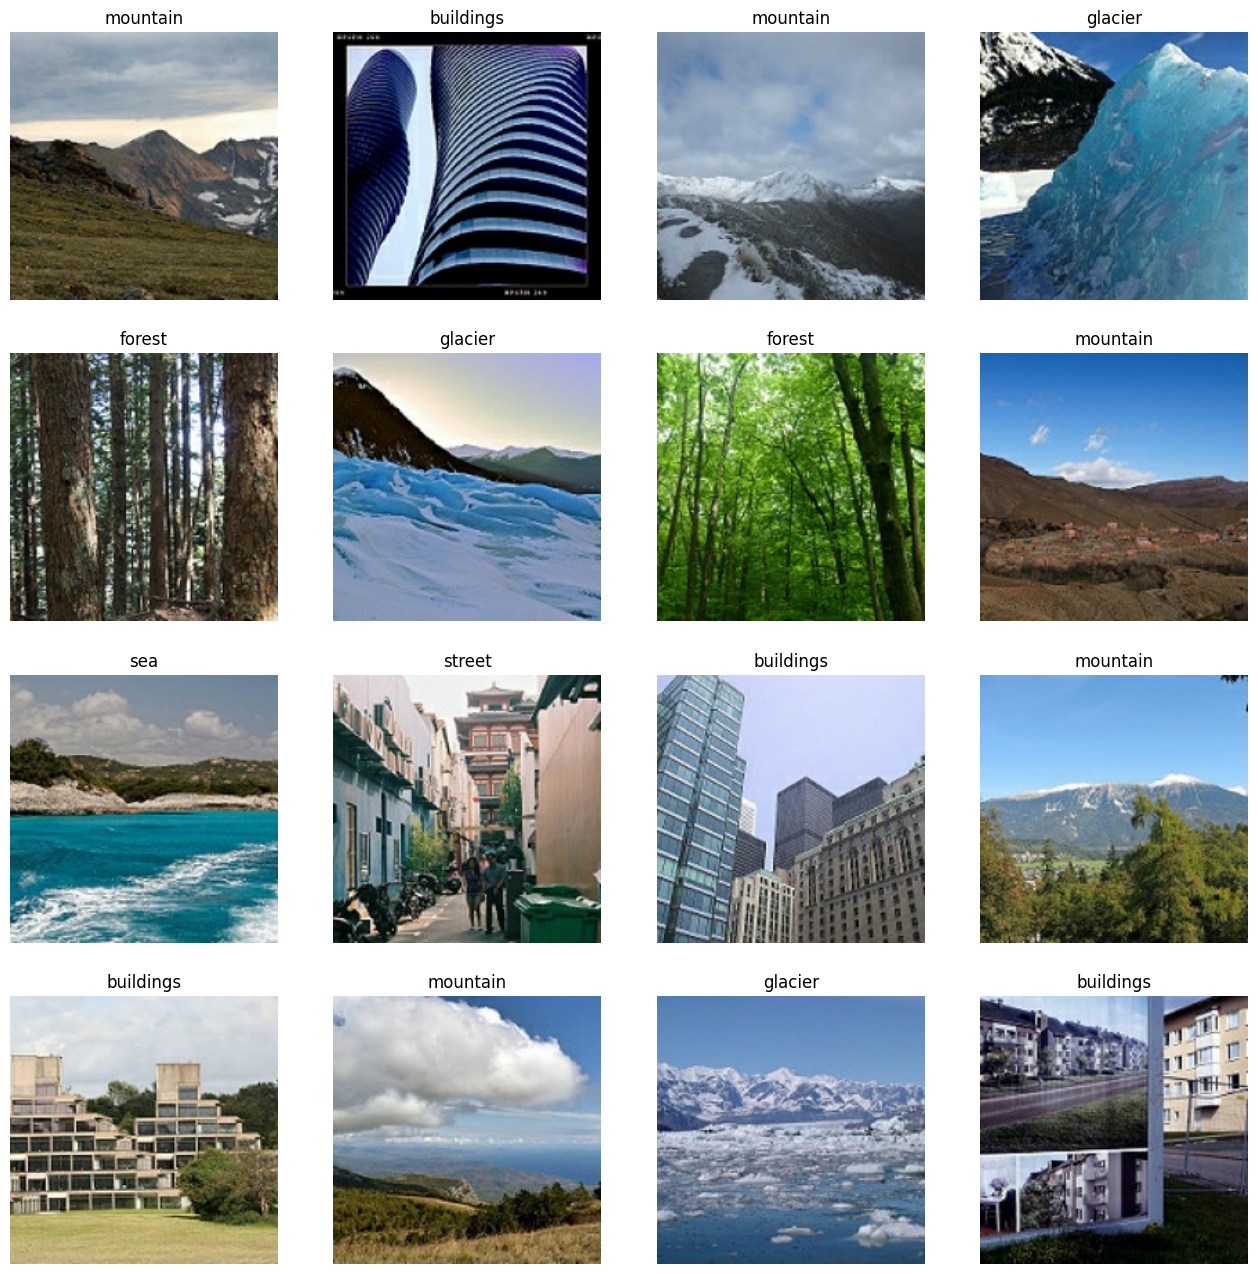

In [10]:
dataset = tf.keras.utils.image_dataset_from_directory(
  train_dir,
  image_size=(224, 224),
  batch_size=16,
  shuffle=True)

def show_images(dataset):
  plt.figure(figsize=(16,16))
  for images, labels in dataset.take(1):
    for i in range(16):
      ax = plt.subplot(4, 4, i + 1)
      ax.imshow(images[i].numpy().astype("uint8"))
      ax.set_title(dataset.class_names[labels[i]])
      ax.axis("off")
  plt.show()

show_images(dataset)

In [11]:
ResNet = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224,3))
preprocess_input = app.resnet50.preprocess_input

94765736/94765736 [==============================] - 5s 0us/step


In [72]:
batch_size=32
train_generator = ImageDataGenerator(horizontal_flip=True,
                                     vertical_flip=True,
                                     rotation_range=20,
                                     validation_split=0.2,
                                     preprocessing_function=preprocess_input)
train_set = train_generator.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    class_mode='binary',
    batch_size=batch_size,
    shuffle=True,
    subset='training'
)

valid_set = train_generator.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    class_mode='binary',
    batch_size=batch_size,
    shuffle=True,
    subset='validation'
)
# step = valid_set.n//32
x_valid, y_valid = valid_set.next()

test_generator = ImageDataGenerator()
test_set = test_generator.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    class_mode='binary',
    batch_size=batch_size
)

Found 11230 images belonging to 6 classes.
Found 2804 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


**Create model**

In [13]:
# Fine-tuning model from layer 142
for layer in ResNet.layers[:143]:
    layer.trainable = False

for layer in ResNet.layers[142:]:
    layer.trainable = True

model = Sequential([
    ResNet,
    GlobalAvgPool2D(),
    Dense(1024, activation='relu'),
    Dense(num_classes, activation='softmax')
], name='ResNet50')
model.summary()

Model: "ResNet50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1024)              2098176   
                                                                 
 dense_1 (Dense)             (None, 6)                 6150      
                                                                 
Total params: 25,692,038
Trainable params: 17,080,326
Non-trainable params: 8,611,712
_________________________________________________________________


**Training**

In [14]:
initial_learning_rate = 0.1
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=5,
    decay_rate=0.95,
    staircase=True)

optimizer = tf.keras.optimizers.Adam(
    learning_rate=lr_schedule)

callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ModelCheckpoint('Resnet.h5', save_best_only=True)
]

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy']
)

In [15]:
history = model.fit(
     train_set, validation_data=valid_set,
     callbacks=callbacks,
     epochs=20, 
     verbose=2
)

Epoch 1/20
351/351 - 206s - loss: 6.0635 - accuracy: 0.7573 - val_loss: 0.3674 - val_accuracy: 0.8734 - 206s/epoch - 588ms/step
Epoch 2/20
351/351 - 172s - loss: 0.3624 - accuracy: 0.8702 - val_loss: 0.3633 - val_accuracy: 0.8777 - 172s/epoch - 490ms/step
Epoch 3/20
351/351 - 172s - loss: 0.3453 - accuracy: 0.8752 - val_loss: 0.3472 - val_accuracy: 0.8812 - 172s/epoch - 490ms/step
Epoch 4/20
351/351 - 173s - loss: 0.3531 - accuracy: 0.8733 - val_loss: 0.3493 - val_accuracy: 0.8827 - 173s/epoch - 493ms/step
Epoch 5/20
351/351 - 172s - loss: 0.3491 - accuracy: 0.8736 - val_loss: 0.3447 - val_accuracy: 0.8780 - 172s/epoch - 490ms/step
Epoch 6/20
351/351 - 171s - loss: 0.3470 - accuracy: 0.8728 - val_loss: 0.3616 - val_accuracy: 0.8773 - 171s/epoch - 486ms/step
Epoch 7/20
351/351 - 171s - loss: 0.3623 - accuracy: 0.8671 - val_loss: 0.3384 - val_accuracy: 0.8816 - 171s/epoch - 487ms/step
Epoch 8/20
351/351 - 170s - loss: 0.3526 - accuracy: 0.8702 - val_loss: 0.3500 - val_accuracy: 0.8866 - 

**Plot learning curve**

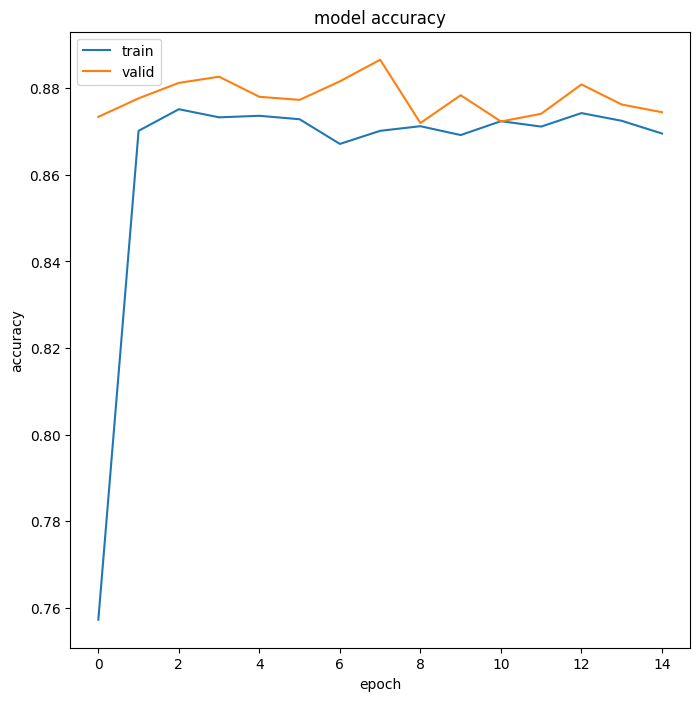

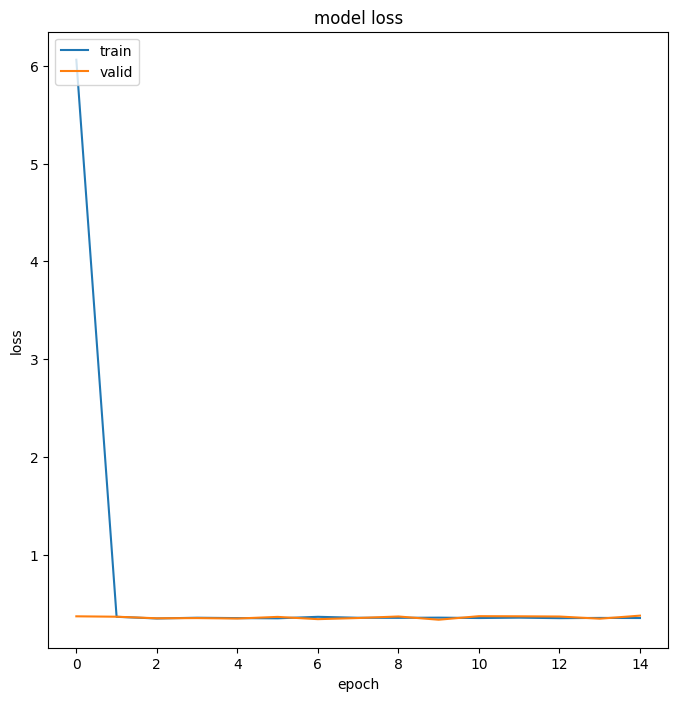

In [20]:
# plot history for accuracy
plt.figure(figsize=(8,8))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

# plot history for loss
plt.figure(figsize=(8,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()


In [21]:
from keras.models import load_model
model_file = './Resnet.h5'
trained_model = load_model(model_file)
trained_model.evaluate(valid_set)

88/88 [==============================] - 35s 381ms/step - loss: 0.3462 - accuracy: 0.8837


[0.346152663230896, 0.8837375044822693]

In [75]:
# y_true = valid_set.labels
y_pred = trained_model.predict(x_valid)

1/1 [==============================] - 0s 44ms/step


In [76]:
y_preds = np.argmax(y_pred, axis=1)
print(y_preds)
print(y_valid)


[5 1 2 4 5 2 0 4 2 1 1 1 3 1 2 1 1 2 4 2 3 2 5 0 5 3 3 1 3 5 5 0]
[5. 1. 2. 4. 5. 2. 0. 4. 2. 1. 1. 1. 4. 1. 2. 1. 1. 2. 4. 2. 3. 2. 5. 0.
 5. 3. 3. 1. 3. 5. 5. 0.]


**Confusion matrix**

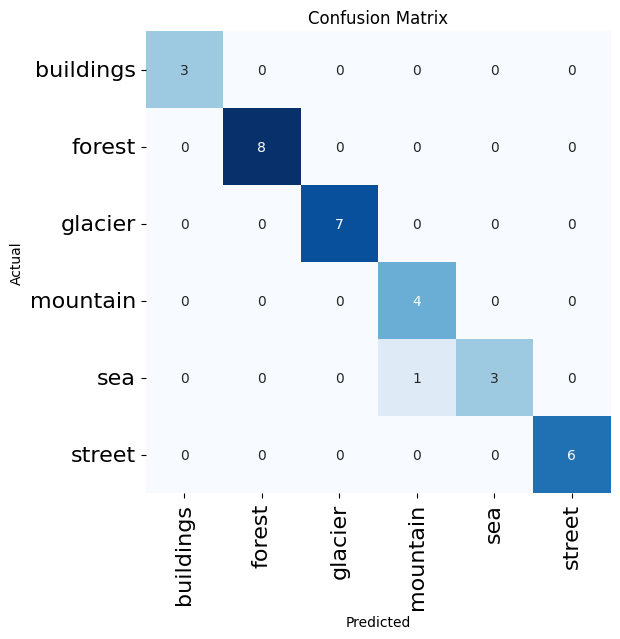

In [77]:
from sklearn.metrics import confusion_matrix
import seaborn as sns 
cm = confusion_matrix(y_valid, y_preds)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False) 
classes = list(test_set.class_indices.keys())      
plt.xticks(np.arange(6)+.5, classes, rotation= 90, fontsize=16)
plt.yticks(np.arange(6)+.5, classes, rotation=0, fontsize=16)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()